In [1]:
from functools import partial

from astropy.constants import G
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import dimensionless, galactic, UnitSystem

import jax
import jax.numpy as jnp

from jax.config import config
config.update("jax_enable_x64", True)

import scienceplots
import cmasher as cmr
plt.style.use('science')
import jax.random as random 
from matplotlib.patches import Ellipse
import time

usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)

import JaxStreams_diffrax as JaxStreams

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
## Define a MW Potential Model
params_global_potential = {'m_disk':5.0e10, 'a_disk': 3.0, 'b_disk': 0.25, 'm_NFW': 1.0e12,
                          'r_s_NFW': 15.0, }
pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params_global_potential['m_disk'], a=params_global_potential['a_disk'],
                                       b=params_global_potential['b_disk'],units=usys)
pot_NFW = JaxStreams.NFWPotential(m=params_global_potential['m_NFW'], r_s=params_global_potential['r_s_NFW'],units=usys)

## Combine potentials
potential_list = [pot_disk,pot_NFW]
pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)


## Gala equivalent
pot_gala_disk = gp.MiyamotoNagaiPotential(m=params_global_potential['m_disk'],a=params_global_potential['a_disk'],
                         b=params_global_potential['b_disk'],units=usys)

pot_gala_NFW = gp.NFWPotential(m=params_global_potential['m_NFW'],r_s=params_global_potential['r_s_NFW'],units=usys)

pot_gala =pot_gala_disk + pot_gala_NFW
H = gp.Hamiltonian(pot_gala)


In [3]:
## Integrate an orbit
t0 = 0.
dt = 0.5
n_steps = 8_000#8_000#8_000
w0 = jnp.array([30., 10., 20, (10*u.km/u.s).to(u.kpc/u.Myr).value, (-150*u.km/u.s).to(u.kpc/u.Myr).value, (-20*u.km/u.s).to(u.kpc/u.Myr).value])

ts = jnp.arange(t0, t0 + dt * n_steps + dt/10., dt)
ws_jax = pot.orbit_integrator_run(w0,t0,jnp.max(ts),ts)#JaxStreams.leapfrog_run(w0, ts, pot.gradient)


w0_gala = gd.PhaseSpacePosition(pos=w0[:3].T*u.kpc,vel=w0[3:].T*u.kpc/u.Myr)
o_gala = H.integrate_orbit(w0=w0_gala,t=np.array(ts))

In [4]:
ts, o_gala.t

(Array([0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 3.9990e+03, 3.9995e+03,
        4.0000e+03], dtype=float64),
 <Quantity [0.0000e+00, 5.0000e-01, 1.0000e+00, ..., 3.9990e+03, 3.9995e+03,
            4.0000e+03] Myr>)

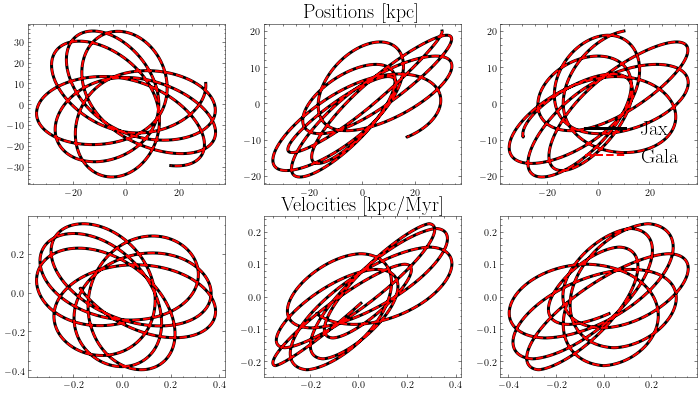

In [5]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6.5)
lw=3
ax[0,0].plot(ws_jax[:,0],ws_jax[:,1],color='k',lw=lw,rasterized=True)
ax[0,1].plot(ws_jax[:,0],ws_jax[:,2],color='k',lw=lw,rasterized=True)
ax[0,2].plot(ws_jax[:,1],ws_jax[:,2],color='k',lw=lw,rasterized=True,label='Jax')

ax[1,0].plot(ws_jax[:,3],ws_jax[:,4],color='k',lw=lw,rasterized=True)
ax[1,1].plot(ws_jax[:,3],ws_jax[:,5],color='k',lw=lw,rasterized=True)
ax[1,2].plot(ws_jax[:,4],ws_jax[:,5],color='k',lw=lw,rasterized=True)


ax[0,0].plot(o_gala.x,o_gala.y,color='r',ls='--',lw=2,rasterized=True)
ax[0,1].plot(o_gala.x,o_gala.z,color='r',ls='--',lw=2,rasterized=True)
ax[0,2].plot(o_gala.y,o_gala.z,color='r',ls='--',lw=2,rasterized=True,label='Gala')

ax[1,0].plot(o_gala.v_x,o_gala.v_y,color='r',ls='--',lw=2,rasterized=True)
ax[1,1].plot(o_gala.v_x,o_gala.v_z,color='r',ls='--',lw=2,rasterized=True)
ax[1,2].plot(o_gala.v_y,o_gala.v_z,color='r',ls='--',lw=2,rasterized=True)

ax[0,1].set_title('Positions [kpc]',fontsize=20)
ax[1,1].set_title('Velocities [kpc/Myr]',fontsize=20)

ax[0,2].legend(fontsize=20)
####plt.savefig('DiskNfw_JaxGalaOrbitInt.pdf',bbox_inches='tight')

In [160]:
lead_arm.shape

(8000, 6)

In [7]:
## Now generate a mock stream along the above orbit
M_sat = 1.0e4 #progenitor mass
start = time.time()
lead_arm, trail_arm = pot.gen_stream_final(ts, w0, M_sat,)
end = time.time()
print(end-start)

2.220020294189453


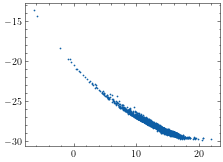

In [157]:
plt.scatter(lead_arm[:,0],lead_arm[:,1],s=0.5,rasterized=True)

In [8]:
jax_stream_model = np.vstack([lead_arm,trail_arm])

In [9]:
## now in gala
from gala.dynamics import mockstream as ms
df = ms.FardalStreamDF()
prog_mass = M_sat * u.Msun
gen = ms.MockStreamGenerator(df, H)
start = time.time()

stream, prog = gen.run(w0_gala, prog_mass,
                        t=np.array(ts)*u.Myr,release_every=1,n_particles=1)
end = time.time()

print(end-start)


13.206675052642822


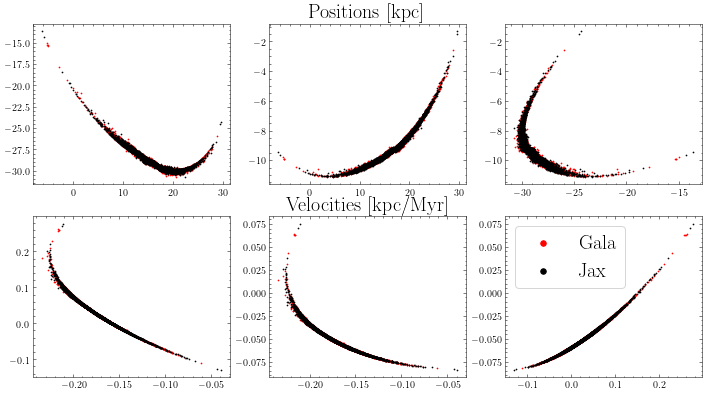

In [10]:
fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6.5)
s=0.5
#ax[0,0].scatter(jax_stream_model[:,0],jax_stream_model[:,1],s=s,rasterized=True,color='k')
ax[0,0].scatter(stream.x,stream.y,s=0.5,rasterized=True,color='r')
ax[0,0].scatter(jax_stream_model[:,0],jax_stream_model[:,1],s=s,rasterized=True,color='k')

ax[0,1].scatter(stream.x,stream.z,s=0.5,rasterized=True,color='r')
ax[0,1].scatter(jax_stream_model[:,0],jax_stream_model[:,2],s=s,rasterized=True,color='k')

ax[0,2].scatter(stream.y,stream.z,s=0.5,rasterized=True,color='r',label='Gala')
ax[0,2].scatter(jax_stream_model[:,1],jax_stream_model[:,2],s=s,rasterized=True,color='k',label='Jax')


ax[1,0].scatter(stream.v_x,stream.v_y,s=0.5,rasterized=True,color='r')
ax[1,0].scatter(jax_stream_model[:,3],jax_stream_model[:,4],s=s,rasterized=True,color='k')

ax[1,1].scatter(stream.v_x,stream.v_z,s=0.5,rasterized=True,color='r')
ax[1,1].scatter(jax_stream_model[:,3],jax_stream_model[:,5],s=s,rasterized=True,color='k')

ax[1,2].scatter(stream.v_y,stream.v_z,s=0.5,rasterized=True,color='r',label='Gala')
ax[1,2].scatter(jax_stream_model[:,4],jax_stream_model[:,5],s=s,rasterized=True,color='k',label='Jax')


ax[0,1].set_title('Positions [kpc]',fontsize=20)
ax[1,1].set_title('Velocities [kpc/Myr]',fontsize=20)

lgnd=ax[1,2].legend(fontsize=20,frameon=True)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
##plt.savefig('DiskSphericalNFW_jax_Gala_Stream.pdf',bbox_inches='tight')

In [9]:
## Benchmar
n_release = [2000,4000,8000,16000,16000*2]
t_jax = []
for i in range(len(n_release)):
    ts = jnp.linspace(t0, 4000., n_release[i])
    start = time.time()
    lead_arm, trail_arm = pot.gen_stream_final(ts, w0, M_sat,)
    end = time.time()
    t_jax.append(end-start)
    print(end-start)
    


0.6241137981414795
1.096452236175537
2.049682855606079
4.160857915878296
13.783693075180054


In [10]:
## now in gala
from gala.dynamics import mockstream as ms
df = ms.FardalStreamDF()
prog_mass = M_sat * u.Msun
gen = ms.MockStreamGenerator(df, H)
#start = time.time()
t_gala = []
for i in range(len(n_release)):
    print('iteration ' + str( i ))
    ts = np.linspace(t0, 4000., n_release[i])
    start = time.time()
    stream, prog = gen.run(w0_gala, prog_mass,
                        t=ts*u.Myr,release_every=1,n_particles=1)
    end = time.time()
    t_gala.append(end-start)
    print(end-start)
    print(len(stream.x))


iteration 0
3.297973871231079
4000
iteration 1
6.6168622970581055
8000
iteration 2
13.64174485206604
16000
iteration 3
24.98160982131958
32000
iteration 4
50.23093605041504
64000


In [12]:
t_gala

[3.297973871231079,
 6.6168622970581055,
 13.64174485206604,
 24.98160982131958,
 50.23093605041504]

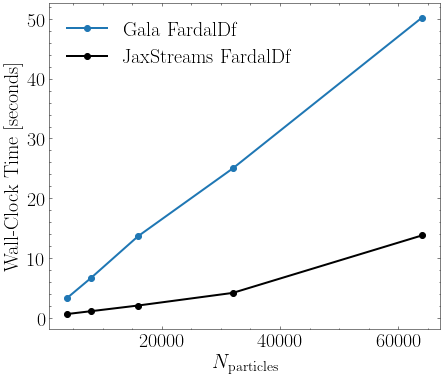

In [13]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7,6)
ax.plot(2*np.array(n_release),t_gala,color='tab:blue',marker='o',lw=2,label='Gala FardalDf',rasterized=True)
ax.plot(2*np.array(n_release),t_jax,color='k',marker='o',lw=2,label='JaxStreams FardalDf',rasterized=True)
ax.set_xlabel(r'$N_{\mathrm{particles}}$',fontsize=20)
ax.set_ylabel(r'Wall-Clock Time [seconds]',fontsize=20)
ax.tick_params(axis='both', labelsize=20)

ax.legend(fontsize=20)
######plt.savefig('Gala_versus_JaxStream_aftercompile.pdf',bbox_inches='tight')

In [ ]:
ts = jnp.linspace(t0, 4000., n_steps)


In [26]:
lead_arm_obs, trail_arm_obs = pot.gen_stream_final(ts, w0, M_sat,)

In [23]:
lead_arm_obs.sum()

Array(-191477.1942843, dtype=float64)

In [27]:
lead_arm_obs.sum()

Array(-191477.1942843, dtype=float64)

In [29]:
pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params_global_potential['m_disk'], a=params_global_potential['a_disk'],
                                               b=params_global_potential['b_disk'],units=usys)
pot_NFW = JaxStreams.NFWPotential(m=params_global_potential['m_NFW'], r_s=params_global_potential['r_s_NFW'],units=usys)

## Combine potentials
potential_list = [pot_disk,pot_NFW]
pot_with_params = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)
lead_arm_obs__, trail_arm_obs__ = pot_with_params.gen_stream_final(ts, w0, M_sat,)

In [32]:
jnp.sum((lead_arm_obs-lead_arm_obs__)**2 + (trail_arm_obs-trail_arm_obs__)**2)

Array(0., dtype=float64)

In [71]:
w0

Array([ 3.00000000e+01,  1.00000000e+01,  2.00000000e+01,  1.02271217e-02,
       -1.53406825e-01, -2.04542433e-02], dtype=float64)

In [136]:
@jax.jit
def gen_observed_stream(params,ts,w0,M_sat):
    pot_disk = JaxStreams.MiyamotoNagaiDisk(m=params['m_disk'], a=params['a_disk'],
                                               b=params['b_disk'],units=usys)
    pot_NFW = JaxStreams.NFWPotential(m=params['m_NFW'], r_s=params['r_s_NFW'],units=usys)
    ## Combine potentials
    potential_list = [pot_disk,pot_NFW]
    pot = JaxStreams.Potential_Combine(potential_list=potential_list,units=usys)
    
    ## Generate a stream. This will be the "observed" stream, i.e., the DATA
    lead_arm, trail_arm = pot.gen_stream_final(ts, w0, M_sat,) 
    
    return lead_arm, trail_arm #jnp.sum(lead_arm_obs**2 + trail_arm_obs**2)
@jax.jit
def compare_streams(params,ts,w0,M_sat):
    ## first generate data stream (no grad tracking)
    lead_arm, trail_arm = gen_observed_stream(params,ts,w0,M_sat)
    lead_arm_obs, trail_arm_obs = jax.lax.stop_gradient(lead_arm), jax.lax.stop_gradient(trail_arm)
    return -jnp.sum( (lead_arm-lead_arm_obs)**2 + (trail_arm-trail_arm_obs)**2 )
    
    

func_params = lambda params: compare_streams(params,ts,w0,M_sat) 
out_test = func_params(params_global_potential)
#@partial(jax.jit,static_argnums=(1,2,))
#@jax.jit
#def get_gradients(params,lead_arm_obs,trail_arm_obs,):
#    return lead_arm_obs
    
#lead_obs_trail_obs = gen_observed_stream(params_global_potential,ts,w0,M_sat)


#test_grad_fn = lambda params: gen_observed_stream(params,ts,w0,M_sat)
#jacc = jax.jacfwd(test_grad_fn)(params_global_potential)

In [147]:
first_deriv = jax.jacfwd(compare_streams,argnums=0)(params_global_potential,ts,w0,M_sat)

In [148]:
first_deriv

{'a_disk': Array(-0., dtype=float64),
 'b_disk': Array(-0., dtype=float64),
 'm_NFW': Array(-0., dtype=float64),
 'm_disk': Array(-0., dtype=float64),
 'r_s_NFW': Array(-0., dtype=float64)}

In [149]:
second_deriv = jax.jacfwd(jax.jacfwd(compare_streams,argnums=0))(params_global_potential,ts,w0,M_sat) #default is argnums=0...

In [150]:
second_deriv

{'a_disk': {'a_disk': Array(-968705.97968917, dtype=float64),
  'b_disk': Array(-63931.34940796, dtype=float64),
  'm_NFW': Array(5.05321794e-05, dtype=float64),
  'm_disk': Array(0.00018556, dtype=float64),
  'r_s_NFW': Array(-4252344.14698589, dtype=float64)},
 'b_disk': {'a_disk': Array(-63931.34940796, dtype=float64),
  'b_disk': Array(-9206.85919985, dtype=float64),
  'm_NFW': Array(5.2091054e-06, dtype=float64),
  'm_disk': Array(2.31089285e-05, dtype=float64),
  'r_s_NFW': Array(-445669.11021175, dtype=float64)},
 'm_NFW': {'a_disk': Array(5.05321794e-05, dtype=float64),
  'b_disk': Array(5.2091054e-06, dtype=float64),
  'm_NFW': Array(-4.86812594e-15, dtype=float64),
  'm_disk': Array(-1.63155041e-14, dtype=float64),
  'r_s_NFW': Array(0.00038021, dtype=float64)},
 'm_disk': {'a_disk': Array(0.00018556, dtype=float64),
  'b_disk': Array(2.31089285e-05, dtype=float64),
  'm_NFW': Array(-1.63155041e-14, dtype=float64),
  'm_disk': Array(-6.34760023e-14, dtype=float64),
  'r_s_NFW